In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from src.classes import BallAnomaly, HitBox, TankProperties32x2
from src.dataprocessing import (
    get_BallAnomaly_properties,
    get_measured_potential,
    get_permarray_FF,
    get_pot_data_FF,
    get_sample,
)
from src.functions import (
    compute_hitbox,
    create_meas_coordinates,
    create_mesh,
    print_coordinates_props,
    set_perm,
)
from src.ML_example import init_train_data
from src.visualization import plot_meas_coords, plot_mesh

## Show single measurement

In [2]:
l_path = "measurements/acryl_skip_8_d_30/"

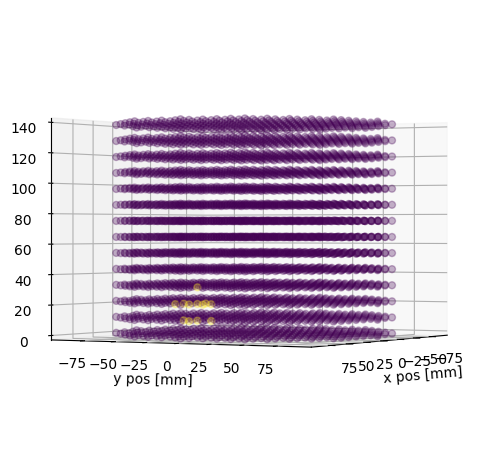

In [3]:
tmp, _ = get_sample(l_path, 17)

tank = tmp["tank"].tolist()
anomaly = get_BallAnomaly_properties(tmp)

mesh_obj = create_mesh(TankProperties32x2())
mesh_obj = set_perm(mesh_obj, anomaly)

plot_mesh(mesh_obj, elev=0)

## Generate Synthetic VAE data

In [2]:
tank = TankProperties32x2()
ball = BallAnomaly(x=0, y=0, z=0, d=30, perm=10, material="acryl")
hitbox = compute_hitbox(tank, ball, safety_tolerance=10.0)
hitbox.z_min = tank.E_zr1 - ball.d / 4
hitbox.z_max = tank.E_zr2 + ball.d / 4
coordinates = create_meas_coordinates(hitbox, x_pts=25, y_pts=25, z_pts=25)

HitBox(x_pts,y_pts,z_pts) leads to 11025 available points.
So 11025 points will be measured.


In [4]:
np.random.shuffle(coordinates)

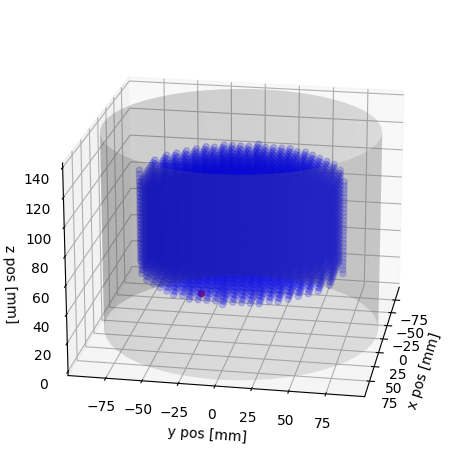

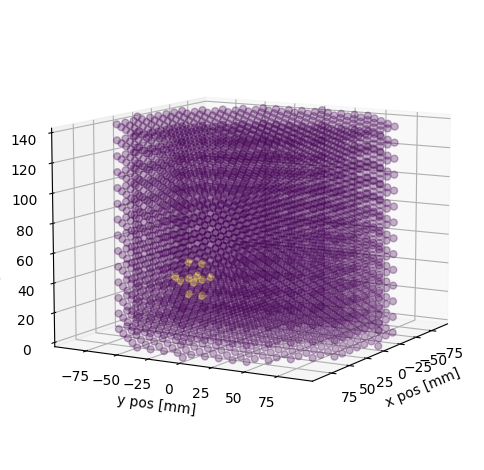

In [5]:
sel_coor_test = 0
plot_meas_coords(tank=tank, meas_coords=coordinates, p_select=sel_coor_test)
ball.x, ball.y, ball.z = coordinates[sel_coor_test]
# create an empty mesh
mesh_obj = create_mesh(tank)
set_perm(mesh_obj, anomaly=ball)
# plot mesh
plot_mesh(mesh_obj, tank)

In [6]:
Perms = list()

for XYZ in coordinates:
    # update ball position
    ball.x, ball.y, ball.z = XYZ
    mesh_obj = set_perm(mesh_obj, ball)
    Perms.append(mesh_obj.perm_array)
Perms = np.array(Perms)
Perms = Perms / 15

Perms_train = Perms

## Load object cloud representation and potential data for ML

In [7]:
Perms_train, Perms_test = train_test_split(  # , Pots_train, Pots_test
    Perms, test_size=0.01, random_state=42  # Pots
)
print(Perms_train.shape, Perms_test.shape)  # , Pots_train.shape, Pots_test.shape)

(10914, 3542) (111, 3542)


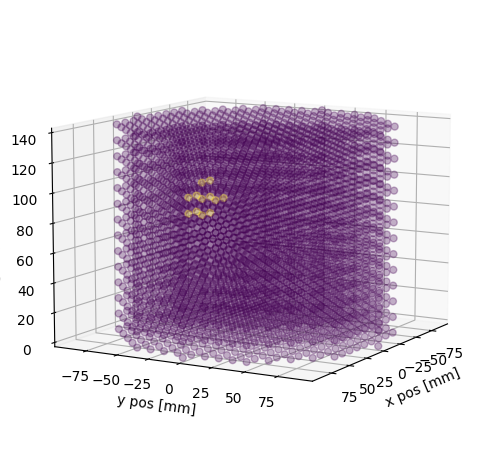

In [8]:
mesh_obj.perm_array = Perms_train[0, :]
plot_mesh(mesh_obj)

In [9]:
import tensorflow as tf
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

latent_dim = 4


class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.mean_squared_error(data, reconstruction)
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.losses.mean_squared_error(inputs, reconstruction)
        )
        reconstruction_loss *= 1912
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss
        self.add_metric(kl_loss, name="kl_loss", aggregation="mean")
        self.add_metric(total_loss, name="total_loss", aggregation="mean")
        self.add_metric(
            reconstruction_loss, name="reconstruction_loss", aggregation="mean"
        )
        return reconstruction

2023-11-20 14:14:41.227963: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 14:14:41.253639: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 14:14:41.254349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 14:14:41.884996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
def encoder_model(inp_shape=(3542,), latent_dim=latent_dim):
    encoder_inputs = keras.Input(shape=inp_shape)
    x = layers.Reshape((3542, 1))(encoder_inputs)
    x = layers.ZeroPadding1D((58, 0))(x)
    x = layers.Conv1D(16, activation="relu", kernel_size=9, strides=2, padding="same")(
        x
    )
    x = layers.Conv1D(16, activation="relu", kernel_size=9, strides=2, padding="same")(
        x
    )
    x = layers.Conv1D(16, activation="relu", kernel_size=9, strides=3, padding="same")(
        x
    )
    x = layers.Conv1D(32, activation="relu", kernel_size=9, strides=2, padding="same")(
        x
    )
    x = layers.Conv1D(32, activation="relu", kernel_size=9, strides=3, padding="same")(
        x
    )
    x = layers.Conv1D(32, activation="relu", kernel_size=9, strides=5, padding="same")(
        x
    )
    x = layers.Flatten()(x)
    x = layers.Dense(320, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling(name="z")([z_mean, z_log_var])

    return encoder_inputs, z_mean, z_log_var, z


def decoder_model(latent_dim=latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")

    x = layers.Dense(16, activation="relu")(latent_inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(320, activation="relu")(x)
    x = layers.Reshape((10, 32))(x)

    x = layers.Conv1DTranspose(
        32, activation="relu", kernel_size=9, strides=5, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        32, activation="relu", kernel_size=9, strides=3, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        16, activation="relu", kernel_size=9, strides=2, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        16, activation="relu", kernel_size=9, strides=3, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        16, activation="relu", kernel_size=9, strides=2, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        1, activation="relu", kernel_size=9, strides=2, padding="same"
    )(x)

    x = layers.Cropping1D(cropping=(58, 0))(x)
    decoder_outputs = layers.Flatten()(x)

    return latent_inputs, decoder_outputs


def vae_model():
    encoder_inputs, z_mean, z_log_var, z = encoder_model()
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="VAE_encoder")
    encoder.summary()

    decoder_inputs, decoder_outputs = decoder_model()
    decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")
    decoder.summary()

    return VAE(encoder, decoder)


vae = vae_model()

Model: "VAE_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3542)]               0         []                            
                                                                                                  
 reshape (Reshape)           (None, 3542, 1)              0         ['input_1[0][0]']             
                                                                                                  
 zero_padding1d (ZeroPaddin  (None, 3600, 1)              0         ['reshape[0][0]']             
 g1D)                                                                                             
                                                                                                  
 conv1d (Conv1D)             (None, 1800, 16)             160       ['zero_padding1d[0][

2023-11-20 14:14:42.464201: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "VAE_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                80        
                                                                 
 dense_4 (Dense)             (None, 64)                1088      
                                                                 
 dense_5 (Dense)             (None, 320)               20800     
                                                                 
 reshape_1 (Reshape)         (None, 10, 32)            0         
                                                                 
 conv1d_transpose (Conv1DTr  (None, 50, 32)            9248      
 anspose)                                                        
                                                       

In [11]:
vae.compile(Adam(), loss=tf.losses.mean_absolute_error)
history = vae.fit(Perms_train, epochs=10, batch_size=256)

Epoch 1/10
43/43 [==============================] - 12s 237ms/step - loss: 0.0029 - reconstruction_loss: 0.0018 - kl_loss: 4.2802e-07
Epoch 2/10
43/43 [==============================] - 10s 235ms/step - loss: 0.0012 - reconstruction_loss: 0.0012 - kl_loss: 0.0000e+00
Epoch 3/10
43/43 [==============================] - 10s 234ms/step - loss: 0.0012 - reconstruction_loss: 0.0012 - kl_loss: 0.0000e+00
Epoch 4/10
43/43 [==============================] - 10s 230ms/step - loss: 0.0012 - reconstruction_loss: 0.0012 - kl_loss: 0.0000e+00
Epoch 5/10
43/43 [==============================] - 10s 231ms/step - loss: 0.0012 - reconstruction_loss: 0.0012 - kl_loss: 0.0000e+00
Epoch 6/10
43/43 [==============================] - 10s 229ms/step - loss: 0.0012 - reconstruction_loss: 0.0012 - kl_loss: 0.0000e+00
Epoch 7/10
43/43 [==============================] - 10s 230ms/step - loss: 0.0012 - reconstruction_loss: 0.0012 - kl_loss: 0.0000e+00
Epoch 8/10
43/43 [==============================] - 10s 230ms/

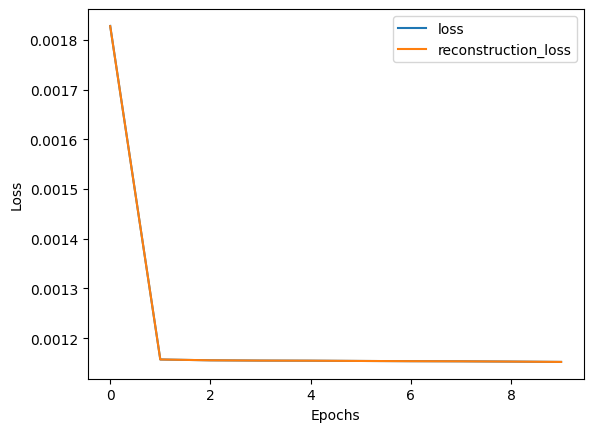

In [12]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

1/1 [==============================] - 0s 145ms/step


<StemContainer object of 3 artists>

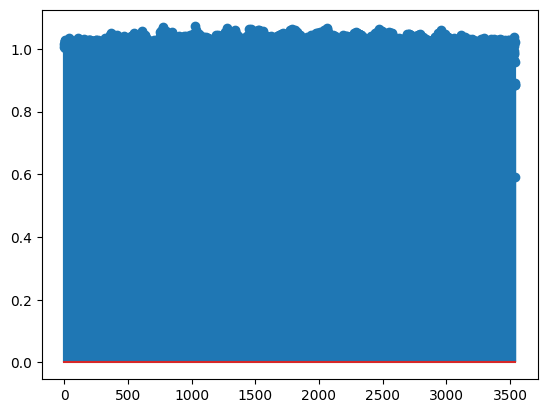

In [13]:
test_pred = vae.decoder.predict(np.expand_dims(np.random.rand(latent_dim), axis=0))
test_pred = np.concatenate(test_pred) * 15
plt.stem(test_pred)

In [14]:
train_z_mean, train_z_log_var, train_z = vae.encoder.predict(Perms_train)
test_z_mean, test_z_log_var, test_z = vae.encoder.predict(Perms_test)

4/4 [==============================] - 0s 3ms/step


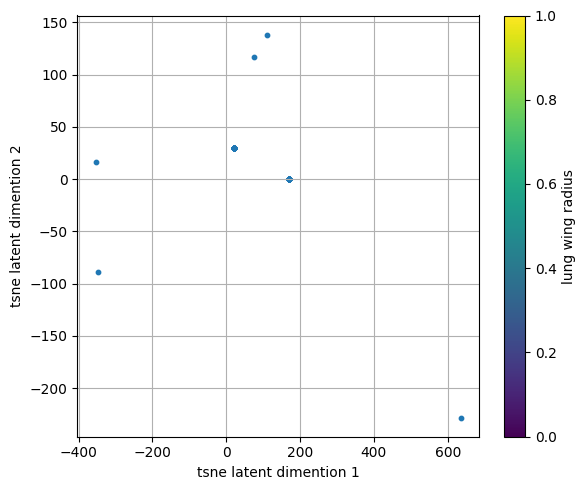

In [15]:
tsne = TSNE(n_components=2)
# latent_space_2d = tsne.fit_transform(train_z_mean)  # latent data
latent_space_2d = tsne.fit_transform(train_z_mean)  # latent data

plt.figure(figsize=(6, 5))
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], s=10)
plt.xlabel("tsne latent dimention 1")
plt.ylabel("tsne latent dimention 2")
plt.colorbar(label="lung wing radius")
plt.grid()
plt.tight_layout()
# plt.savefig("../../beauty_of_latent_spaces/5.pdf")
plt.show()

In [60]:
def mapper(input_shape=(4096,), latent_dim=8):
    mapper_inputs = layers.Input(shape=input_shape)
    x = layers.Reshape((4096, 1))(mapper_inputs)
    x = layers.Conv1D(128, strides=2, kernel_size=9)(x)
    x = layers.Conv1D(64, strides=4, kernel_size=9)(x)
    x = layers.Conv1D(32, strides=4, kernel_size=9)(x)
    x = layers.Conv1D(16, strides=4, kernel_size=9)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.Dense(latent_dim, activation="relu")(x)

    return Model(mapper_inputs, x)


mapper = mapper()
mapper.compile(Adam(), loss=tf.keras.losses.mean_squared_error)
mapper.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4096)]            0         
                                                                 
 reshape_2 (Reshape)         (None, 4096, 1)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 2044, 128)         1280      
                                                                 
 conv1d_7 (Conv1D)           (None, 509, 64)           73792     
                                                                 
 conv1d_8 (Conv1D)           (None, 126, 32)           18464     
                                                                 
 conv1d_9 (Conv1D)           (None, 30, 16)            4624      
                                                                 
 flatten_2 (Flatten)         (None, 480)               0     

In [23]:
history_mapper = mapper.fit(Pots_train, train_z, epochs=50, batch_size=128)

Epoch 1/50
1/1 [==============================] - 1s 647ms/step - loss: 1.0304
Epoch 2/50
1/1 [==============================] - 0s 141ms/step - loss: 1.0584
Epoch 3/50
1/1 [==============================] - 0s 145ms/step - loss: 1.0246
Epoch 4/50
1/1 [==============================] - 0s 144ms/step - loss: 1.0302
Epoch 5/50
1/1 [==============================] - 0s 142ms/step - loss: 1.0302
Epoch 6/50
1/1 [==============================] - 0s 143ms/step - loss: 1.0298
Epoch 7/50
1/1 [==============================] - 0s 138ms/step - loss: 1.0303
Epoch 8/50
1/1 [==============================] - 0s 143ms/step - loss: 1.0297
Epoch 9/50
1/1 [==============================] - 0s 144ms/step - loss: 1.0302
Epoch 10/50
1/1 [==============================] - 0s 143ms/step - loss: 1.0298
Epoch 11/50
1/1 [==============================] - 0s 143ms/step - loss: 1.0300
Epoch 12/50
1/1 [==============================] - 0s 144ms/step - loss: 1.0299
Epoch 13/50
1/1 [==============================] 

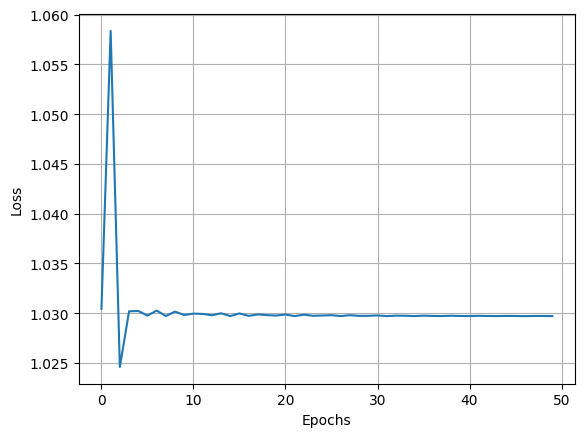

In [24]:
plt.plot(history_mapper.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [25]:
Perm_pred = vae.decoder.predict(mapper.predict(Pots_train)) * 15

3/3 [==============================] - 0s 5ms/step


<StemContainer object of 3 artists>

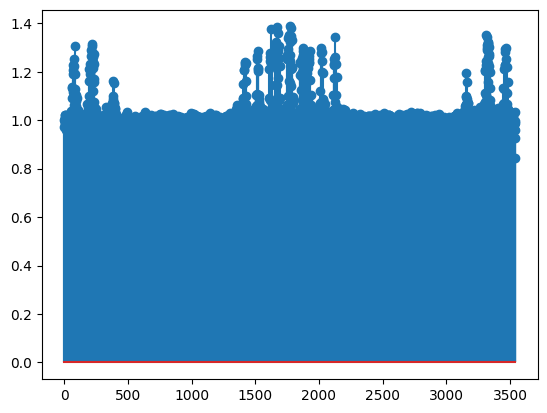

In [28]:
plt.stem(Perm_pred[0, :])

<StemContainer object of 3 artists>

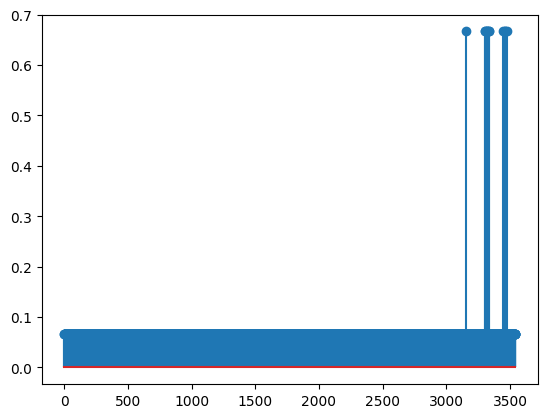

In [29]:
plt.stem(Perms_train[0, :])

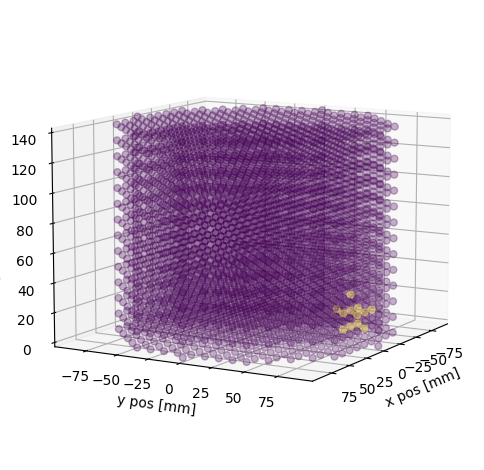

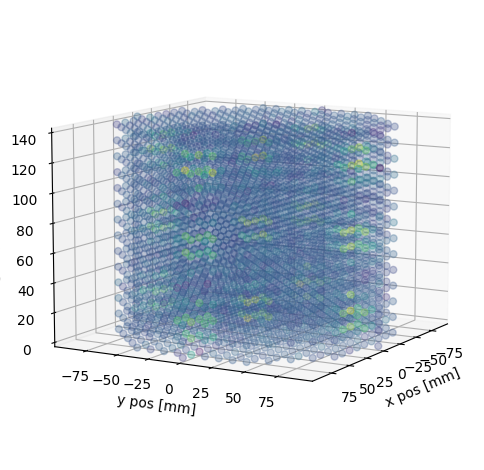

In [34]:
mesh_obj.perm_array = Perms_train[0, :]
plot_mesh(mesh_obj)
mesh_obj.perm_array = Perm_pred[0, :]
plot_mesh(mesh_obj)